# Phase 1: German Anchor Extraction

## Goal
Extract high-confidence hieroglyphic ↔ German word pairs from our combined corpus.
These anchors will be translated to English and used for alignment.

## Strategy
Following V3's successful approach:
1. Build co-occurrence matrix between hieroglyphic and German words
2. Calculate conditional probability P(german|hieroglyphic)
3. Filter for high-confidence pairs (>30% co-occurrence)
4. Minimum occurrence threshold (5+ times)
5. Extract ~2,000 anchors for translation

In [1]:
import pandas as pd
import json
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import re

# Load the combined corpus
corpus_path = Path('../data/processed/hieroglyphic_corpus_full.tsv')
df = pd.read_csv(corpus_path, sep='\t')

print(f"Total records: {len(df):,}")
print(f"Records with translation: {df['translation'].notna().sum():,}")

Total records: 104,426
Records with translation: 95,314


In [2]:
# Filter for records with both transliteration and translation
df_parallel = df[
    (df['transliteration_clean'].notna()) & 
    (df['transliteration_clean'] != '') &
    (df['translation'].notna()) & 
    (df['translation'] != '')
].copy()

print(f"Parallel sentences: {len(df_parallel):,}")
print(f"\nSample:")
print(df_parallel[['transliteration_clean', 'translation']].head(3))

Parallel sentences: 95,314

Sample:
                                  transliteration_clean  \
9088  pꜣ (j)m(y)-r(ꜣ) mšꜥ.w n pr-ꜥꜣ ꜥ.w.s n pꜣ ꜥꜣ n ...   
9089  ḥnꜥ-ḏd r-nty sš ṯry n pꜣ ḫr ḥry pḏ.t ḥm-nṯr šd...   
9090                     ꜥn w n j smj w n pꜣ j.jr tn nb   

                                            translation  
9088  Le général de Pharaon, VSF, [aux] deux chefs d...  
9089  Le scribe de la Tombe ṯry et le supérieur des ...  
9090  Ils m'ont rendu leur rapport de tout ce que vo...  


In [3]:
# Clean German text (similar to V3's approach)
def clean_german(text):
    """Normalize German text."""
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation but keep umlauts
    text = re.sub(r'[^a-zäöüß0-9\s]', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
print("Cleaning German translations...")
df_parallel['german_clean'] = df_parallel['translation'].apply(clean_german)

# Remove empty
df_parallel = df_parallel[df_parallel['german_clean'] != ''].copy()
print(f"After cleaning: {len(df_parallel):,} parallel sentences")

Cleaning German translations...


After cleaning: 95,164 parallel sentences


In [4]:
# Build co-occurrence matrix
print("Building co-occurrence matrix...")
co_occurrence = Counter()
h_freq = Counter()
g_freq = Counter()

for _, row in tqdm(df_parallel.iterrows(), total=len(df_parallel), desc="Processing"):
    h_words = set(row['transliteration_clean'].split())
    g_words = set(row['german_clean'].split())
    
    for h in h_words:
        h_freq[h] += 1
        for g in g_words:
            co_occurrence[(h, g)] += 1
            g_freq[g] += 1

print(f"\nUnique hieroglyphic words: {len(h_freq):,}")
print(f"Unique German words: {len(g_freq):,}")
print(f"Total co-occurrences: {len(co_occurrence):,}")

Building co-occurrence matrix...


Processing:   0%|               | 0/95164 [00:00<?, ?it/s]

Processing:   1%| | 1281/95164 [00:00<00:07, 12783.01it/s]

Processing:   3%| | 2678/95164 [00:00<00:06, 13464.74it/s]

Processing:   4%| | 4025/95164 [00:00<00:07, 12332.66it/s]

Processing:   6%| | 5269/95164 [00:00<00:07, 11518.01it/s]

Processing:   7%| | 6524/95164 [00:00<00:07, 11857.94it/s]

Processing:   8%| | 7720/95164 [00:00<00:07, 11693.36it/s]

Processing:   9%|▏ | 8896/95164 [00:00<00:09, 9367.11it/s]

Processing:  10%|▏ | 9901/95164 [00:00<00:09, 8574.55it/s]

Processing:  11%| | 10809/95164 [00:01<00:10, 7731.15it/s]

Processing:  12%| | 11623/95164 [00:01<00:11, 7388.76it/s]

Processing:  13%|▏| 12387/95164 [00:01<00:12, 6888.90it/s]

Processing:  14%|▏| 13093/95164 [00:01<00:11, 6873.80it/s]

Processing:  15%|▏| 13828/95164 [00:01<00:11, 6995.55it/s]

Processing:  15%|▏| 14579/95164 [00:01<00:11, 7133.45it/s]

Processing:  16%|▏| 15302/95164 [00:01<00:11, 7064.25it/s]

Processing:  17%|▏| 16288/95164 [00:01<00:10, 7849.72it/s]

Processing:  18%|▏| 17158/95164 [00:01<00:09, 8092.64it/s]

Processing:  19%|▏| 17976/95164 [00:02<00:10, 7622.46it/s]

Processing:  20%|▏| 18871/95164 [00:02<00:09, 7994.61it/s]

Processing:  21%|▏| 19693/95164 [00:02<00:09, 8055.80it/s]

Processing:  22%|▏| 20606/95164 [00:02<00:08, 8367.08it/s]

Processing:  23%|▏| 21449/95164 [00:02<00:09, 7845.24it/s]

Processing:  23%|▏| 22244/95164 [00:02<00:09, 7702.60it/s]

Processing:  24%|▏| 23022/95164 [00:02<00:09, 7510.61it/s]

Processing:  25%|▏| 23779/95164 [00:02<00:09, 7170.40it/s]

Processing:  26%|▎| 24502/95164 [00:02<00:10, 6990.10it/s]

Processing:  27%|▎| 25469/95164 [00:03<00:09, 7728.42it/s]

Processing:  28%|▎| 26278/95164 [00:03<00:08, 7822.26it/s]

Processing:  28%|▎| 27115/95164 [00:03<00:08, 7976.41it/s]

Processing:  29%|▎| 27939/95164 [00:03<00:08, 8050.34it/s]

Processing:  30%|▎| 28748/95164 [00:03<00:09, 7186.48it/s]

Processing:  31%|▎| 29486/95164 [00:03<00:09, 6697.36it/s]

Processing:  32%|▎| 30174/95164 [00:03<00:09, 6541.97it/s]

Processing:  33%|▎| 30979/95164 [00:03<00:09, 6944.50it/s]

Processing:  33%|▎| 31687/95164 [00:03<00:09, 6889.54it/s]

Processing:  34%|▎| 32509/95164 [00:04<00:08, 7262.71it/s]

Processing:  35%|▎| 33364/95164 [00:04<00:08, 7628.83it/s]

Processing:  36%|▎| 34141/95164 [00:04<00:07, 7669.77it/s]

Processing:  37%|▎| 35125/95164 [00:04<00:07, 8305.15it/s]

Processing:  38%|▍| 36280/95164 [00:04<00:06, 9157.60it/s]

Processing:  39%|▍| 37275/95164 [00:04<00:06, 9389.42it/s]

Processing:  40%|▍| 38251/95164 [00:04<00:06, 9475.38it/s]

Processing:  41%|▍| 39290/95164 [00:04<00:05, 9745.08it/s]

Processing:  42%|▍| 40268/95164 [00:04<00:05, 9755.24it/s]

Processing:  44%|▍| 41397/95164 [00:04<00:05, 10193.36it/s

Processing:  45%|▍| 42418/95164 [00:05<00:05, 9879.13it/s]

Processing:  46%|▍| 43409/95164 [00:05<00:05, 9296.21it/s]

Processing:  47%|▍| 44397/95164 [00:05<00:05, 9458.95it/s]

Processing:  48%|▍| 45350/95164 [00:05<00:05, 9212.69it/s]

Processing:  49%|▍| 46277/95164 [00:05<00:05, 8964.20it/s]

Processing:  50%|▍| 47268/95164 [00:05<00:05, 9228.41it/s]

Processing:  51%|▌| 48196/95164 [00:05<00:05, 8508.61it/s]

Processing:  52%|▌| 49060/95164 [00:05<00:05, 7926.81it/s]

Processing:  52%|▌| 49867/95164 [00:05<00:05, 7820.24it/s]

Processing:  54%|▌| 51167/95164 [00:06<00:04, 9230.02it/s]

Processing:  55%|▌| 52291/95164 [00:06<00:04, 9792.57it/s]

Processing:  56%|▌| 53384/95164 [00:06<00:04, 10114.04it/s

Processing:  57%|▌| 54410/95164 [00:06<00:04, 8809.50it/s]

Processing:  58%|▌| 55330/95164 [00:06<00:04, 8714.72it/s]

Processing:  59%|▌| 56228/95164 [00:06<00:04, 8430.71it/s]

Processing:  60%|▌| 57328/95164 [00:06<00:04, 9120.69it/s]

Processing:  61%|▌| 58261/95164 [00:06<00:04, 9063.85it/s]

Processing:  62%|▌| 59330/95164 [00:06<00:03, 9516.04it/s]

Processing:  63%|▋| 60295/95164 [00:07<00:03, 9471.90it/s]

Processing:  64%|▋| 61251/95164 [00:07<00:03, 9206.69it/s]

Processing:  65%|▋| 62323/95164 [00:07<00:03, 9629.36it/s]

Processing:  67%|▋| 63293/95164 [00:07<00:03, 9313.85it/s]

Processing:  67%|▋| 64231/95164 [00:07<00:03, 9292.18it/s]

Processing:  69%|▋| 65279/95164 [00:07<00:03, 9631.33it/s]

Processing:  70%|▋| 66247/95164 [00:07<00:03, 9373.84it/s]

Processing:  71%|▋| 67189/95164 [00:07<00:03, 8623.76it/s]

Processing:  72%|▋| 68065/95164 [00:07<00:03, 8593.14it/s]

Processing:  72%|▋| 68934/95164 [00:08<00:03, 7624.47it/s]

Processing:  73%|▋| 69919/95164 [00:08<00:03, 8205.31it/s]

Processing:  74%|▋| 70765/95164 [00:08<00:03, 7834.54it/s]

Processing:  75%|▊| 71567/95164 [00:08<00:03, 5978.76it/s]

Processing:  76%|▊| 72413/95164 [00:08<00:03, 6537.80it/s]

Processing:  77%|▊| 73420/95164 [00:08<00:02, 7397.54it/s]

Processing:  78%|▊| 74283/95164 [00:08<00:02, 7715.32it/s]

Processing:  79%|▊| 75108/95164 [00:09<00:03, 6303.83it/s]

Processing:  80%|▊| 75815/95164 [00:09<00:03, 6351.80it/s]

Processing:  82%|▊| 77903/95164 [00:09<00:01, 9956.57it/s]

Processing:  83%|▊| 79012/95164 [00:09<00:01, 9548.65it/s]

Processing:  84%|▊| 80048/95164 [00:09<00:01, 8940.19it/s]

Processing:  85%|▊| 81003/95164 [00:09<00:01, 8817.64it/s]

Processing:  86%|▊| 81926/95164 [00:09<00:01, 8314.98it/s]

Processing:  87%|▊| 82788/95164 [00:09<00:01, 8145.26it/s]

Processing:  88%|▉| 83623/95164 [00:09<00:01, 7796.16it/s]

Processing:  89%|▉| 84428/95164 [00:10<00:01, 7862.67it/s]

Processing:  90%|▉| 85225/95164 [00:10<00:01, 7706.22it/s]

Processing:  90%|▉| 86003/95164 [00:10<00:01, 7460.93it/s]

Processing:  91%|▉| 86765/95164 [00:10<00:01, 7502.25it/s]

Processing:  92%|▉| 87520/95164 [00:10<00:01, 7244.25it/s]

Processing:  93%|▉| 88283/95164 [00:10<00:00, 7350.11it/s]

Processing:  94%|▉| 89022/95164 [00:10<00:00, 6502.30it/s]

Processing:  94%|▉| 89691/95164 [00:10<00:00, 5572.59it/s]

Processing:  95%|▉| 90280/95164 [00:11<00:00, 5041.49it/s]

Processing:  95%|▉| 90811/95164 [00:11<00:00, 4935.37it/s]

Processing:  96%|▉| 91322/95164 [00:11<00:00, 4667.31it/s]

Processing:  96%|▉| 91800/95164 [00:11<00:00, 4381.04it/s]

Processing:  97%|▉| 92246/95164 [00:11<00:00, 3938.16it/s]

Processing:  97%|▉| 92733/95164 [00:11<00:00, 4156.90it/s]

Processing:  98%|▉| 93161/95164 [00:11<00:00, 4069.28it/s]

Processing:  98%|▉| 93614/95164 [00:11<00:00, 4187.27it/s]

Processing:  99%|▉| 94140/95164 [00:11<00:00, 4478.58it/s]

Processing:  99%|▉| 94596/95164 [00:12<00:00, 4482.44it/s]

Processing: 100%|▉| 95104/95164 [00:12<00:00, 4644.22it/s]

Processing: 100%|█| 95164/95164 [00:12<00:00, 7784.77it/s]


Unique hieroglyphic words: 80,179
Unique German words: 51,181
Total co-occurrences: 4,497,832


In [5]:
# Extract anchors with confidence threshold
MIN_COUNT = 5
CONFIDENCE_THRESHOLD = 0.3

anchors = {}

print("Extracting anchors...")
for (h, g), count in tqdm(co_occurrence.items(), desc="Filtering"):
    if count < MIN_COUNT:
        continue
    
    # Conditional probability P(g|h)
    prob = count / h_freq[h]
    
    if prob > CONFIDENCE_THRESHOLD:
        # Keep the best translation for each hieroglyphic word
        if h not in anchors or anchors[h]['prob'] < prob:
            anchors[h] = {
                'german': g,
                'prob': prob,
                'count': count
            }

print(f"\nFound {len(anchors):,} potential anchors")

Extracting anchors...


Filtering:   0%|              | 0/4497832 [00:00<?, ?it/s]

Filtering:   8%| | 379558/4497832 [00:00<00:01, 3795438.84

Filtering:  18%|▏| 831804/4497832 [00:00<00:00, 4223040.86

Filtering:  28%|▎| 1254109/4497832 [00:00<00:00, 4046333.6

Filtering:  39%|▍| 1762963/4497832 [00:00<00:00, 4447135.0

Filtering:  51%|▌| 2294398/4497832 [00:00<00:00, 4754639.3

Filtering:  62%|▌| 2805115/4497832 [00:00<00:00, 4873158.5

Filtering:  74%|▋| 3346954/4497832 [00:00<00:00, 5050059.5

Filtering:  86%|▊| 3888148/4497832 [00:00<00:00, 5164643.9

Filtering:  99%|▉| 4446449/4497832 [00:00<00:00, 5294941.7

Filtering: 100%|█| 4497832/4497832 [00:00<00:00, 4894273.2


Found 8,541 potential anchors


In [6]:
# Display top anchors
sorted_anchors = sorted(anchors.items(), key=lambda x: x[1]['count'], reverse=True)

print("\nTop 30 Anchors (by frequency):")
print("="*70)
for i, (h, data) in enumerate(sorted_anchors[:30], 1):
    print(f"{i:2d}. {h:15s} → {data['german']:20s} (prob: {data['prob']:.2f}, count: {data['count']:,})")


Top 30 Anchors (by frequency):
 1. n               → der                  (prob: 0.34, count: 8,829)
 2. m               → der                  (prob: 0.37, count: 8,467)
 3. =f              → er                   (prob: 0.38, count: 8,328)
 4. =k              → du                   (prob: 0.45, count: 6,891)
 5. =j              → ich                  (prob: 0.60, count: 6,112)
 6. ḥr              → der                  (prob: 0.30, count: 3,510)
 7. r               → der                  (prob: 0.31, count: 3,443)
 8. wsjr            → osiris               (prob: 0.98, count: 2,322)
 9. =sn             → sie                  (prob: 0.51, count: 2,146)
10. pw              → ist                  (prob: 0.64, count: 1,959)
11. pꜣ              → der                  (prob: 0.37, count: 1,910)
12. 1               → 1                    (prob: 0.85, count: 1,904)
13. nb              → der                  (prob: 0.42, count: 1,832)
14. ppy             → pepi                 (prob: 0.99, co

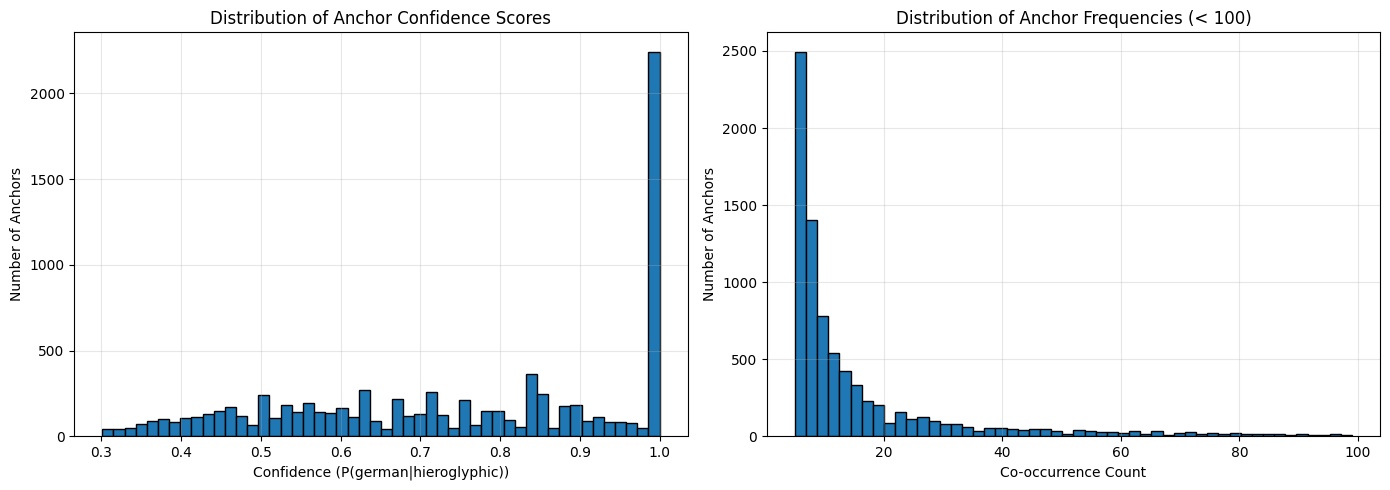


Anchor Statistics:
Mean confidence: 0.747
Median confidence: 0.765
Mean frequency: 38.0
Median frequency: 9


In [7]:
# Analyze anchor quality
import matplotlib.pyplot as plt

# Distribution of confidence scores
probs = [data['prob'] for data in anchors.values()]
counts = [data['count'] for data in anchors.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(probs, bins=50, edgecolor='black')
ax1.set_xlabel('Confidence (P(german|hieroglyphic))')
ax1.set_ylabel('Number of Anchors')
ax1.set_title('Distribution of Anchor Confidence Scores')
ax1.grid(alpha=0.3)

ax2.hist([c for c in counts if c < 100], bins=50, edgecolor='black')
ax2.set_xlabel('Co-occurrence Count')
ax2.set_ylabel('Number of Anchors')
ax2.set_title('Distribution of Anchor Frequencies (< 100)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/anchor_quality_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAnchor Statistics:")
print(f"Mean confidence: {sum(probs)/len(probs):.3f}")
print(f"Median confidence: {sorted(probs)[len(probs)//2]:.3f}")
print(f"Mean frequency: {sum(counts)/len(counts):.1f}")
print(f"Median frequency: {sorted(counts)[len(counts)//2]}")

In [8]:
# Save anchors for translation
import pickle

# Create anchor list
anchor_list = [
    {
        'hieroglyphic': h,
        'german': data['german'],
        'confidence': data['prob'],
        'frequency': data['count']
    }
    for h, data in sorted_anchors
]

# Save as pickle
output_path = Path('../data/processed/german_anchors.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(anchor_list, f)

# Also save as JSON for readability
json_path = Path('../data/processed/german_anchors.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(anchor_list, f, ensure_ascii=False, indent=2)

print(f"\nSaved {len(anchor_list):,} anchors to:")
print(f"  - {output_path}")
print(f"  - {json_path}")


Saved 8,541 anchors to:
  - ../data/processed/german_anchors.pkl
  - ../data/processed/german_anchors.json


## Next Steps

### Phase 2: Selective Translation
We now have ~2,000 German anchor words to translate to English.

**Options:**
1. **DeepL API** (recommended for German→English, very accurate)
2. **Google Translate API** (good alternative)
3. **Manual review** of top 100 most frequent words

**Cost estimate:**
- DeepL: ~$20 for 500k characters (our ~2k words ≈ 20k characters = $1)
- Google: Similar pricing

**Implementation:**
Create `05_translate_anchors.ipynb` to:
1. Load `german_anchors.json`
2. Batch translate German words to English
3. Manual review/correction of top 100
4. Save as `english_anchors.pkl`